In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn import svm
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import statsmodels.graphics.regressionplots as smg
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV

###Import training and validation data

In [2]:
train = pd.read_csv(r'C:\Users\abact\BC-Project\data\train_data.csv')
valid = pd.read_csv(r'C:\Users\abact\BC-Project\data\val_data.csv')
test = pd.read_csv(r'C:\Users\abact\BC-Project\data\test_data.csv')
print(train)

     Increase  Decrease  Level      CPI  Unemployment Rate  Retail Sales  \
0        0.00       0.5   3.75  144.200                7.1      160605.0   
1        0.00       0.0   3.25  144.500                6.9      162816.0   
2        0.00       0.0   3.25  144.800                6.8      162506.0   
3        0.00       0.0   3.25  145.000                6.7      163258.0   
4        0.00       0.0   3.25  146.000                6.6      166594.0   
..        ...       ...    ...      ...                ...           ...   
186      0.00       0.0   0.50  241.176                5.0      406064.0   
187      0.25       0.0   0.50  241.741                4.9      407120.0   
188      0.00       0.0   0.75  242.637                4.7      412576.0   
189      0.25       0.0   0.75  243.618                4.7      415749.0   
190      0.00       0.0   1.00  243.892                4.4      414836.0   

     Durable Goods Orders  Short-Term Treasury Bond Rate  \
0                126529.0  

###Start with basic linear models

###Best Variable Selection

In [3]:
# Create a copy of the 'train' DataFrame
test_data = train.copy()

# Create an empty DataFrame to store the results
variable_selection_results = pd.DataFrame(columns=['Variable', 't-statistic', 'p-value'])

# Convert 'Date' column to numeric temporarily
test_data['Date_numeric'] = pd.to_numeric(test_data['Date'], errors='coerce')

# Iterate over each predictor variable in the 'test_data' dataset
for predictor_variable in test_data.columns:
    if predictor_variable != 'Difference' and predictor_variable != 'Date':
        # Convert predictor variable to numeric type
        test_data[predictor_variable] = pd.to_numeric(test_data[predictor_variable], errors='coerce')
        
        # Perform the t-test
        t_stat, p_value = stats.ttest_ind(test_data[predictor_variable], test_data['Difference'], nan_policy='omit')
        
        # Store the results in the DataFrame
        variable_selection_results = variable_selection_results.append({
            'Variable': predictor_variable,
            't-statistic': t_stat,
            'p-value': p_value
        }, ignore_index=True)

# Sort the results by p-value in ascending order
variable_selection_results = variable_selection_results.sort_values(by='p-value', ascending=True)

# Convert 'Date_numeric' back to a date
test_data['Date_numeric'] = pd.to_datetime(test_data['Date_numeric'], errors='coerce')

# Print the variable selection results
print(variable_selection_results)

C:\Users\abact\AppData\Local\Temp\ipykernel_14712\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  variable_selection_results = variable_selection_results.append({
C:\Users\abact\AppData\Local\Temp\ipykernel_14712\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  variable_selection_results = variable_selection_results.append({
C:\Users\abact\AppData\Local\Temp\ipykernel_14712\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  variable_selection_results = variable_selection_results.append({
C:\Users\abact\AppData\Local\Temp\ipykernel_14712\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

                            Variable t-statistic   p-value
3                                CPI   87.047291       0.0
25  Durable Goods Orders_RollingMean    86.84105       0.0
6               Durable Goods Orders   86.048734       0.0
14           Average Hourly Earnings   68.095082       0.0
5                       Retail Sales   55.912999       0.0
..                               ...         ...       ...
10                               LEI   -0.362377  0.717272
35                            attain    0.253871  0.799733
85                        surpassing   -0.089933  0.928388
86                        tremendous   -0.089933  0.928388
96                      Date_numeric          --        --

[97 rows x 3 columns]


C:\Users\abact\AppData\Local\Temp\ipykernel_14712\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  variable_selection_results = variable_selection_results.append({
C:\Users\abact\AppData\Local\Temp\ipykernel_14712\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  variable_selection_results = variable_selection_results.append({
C:\Users\abact\AppData\Local\Temp\ipykernel_14712\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  variable_selection_results = variable_selection_results.append({
C:\Users\abact\AppData\Local\Temp\ipykernel_14712\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

###Subset Selection

In [4]:
top_15_variable_names = variable_selection_results['Variable'].head(15)
top_15_variable_names

3                                  CPI
25    Durable Goods Orders_RollingMean
6                 Durable Goods Orders
14             Average Hourly Earnings
5                         Retail Sales
24            Retail Sales_RollingMean
4                    Unemployment Rate
8         Long-Term Treasury Bond Rate
19        Standardized Sentiment Score
2                                Level
7        Short-Term Treasury Bond Rate
70                                risk
17                  Negative Frequency
83                           suggested
31                            appeared
Name: Variable, dtype: object

In [5]:
# Add the selected independent variables to the model
X = sm.add_constant(train[top_15_variable_names])

# Fit the OLS model
model = sm.OLS(train['Difference'], X).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     5.604
Date:                Fri, 21 Jul 2023   Prob (F-statistic):           2.85e-09
Time:                        16:05:02   Log-Likelihood:                 73.258
No. Observations:                 191   AIC:                            -114.5
Df Residuals:                     175   BIC:                            -62.48
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [6]:
# Calculate Mean Squared Error (MSE)
mse = model.mse_resid

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print MSE and RMSE
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
# Print the AIC and AICc
print("AIC:", model.aic)
print("AICc:", model.bic)

Mean Squared Error (MSE): 0.029673745552444918
Root Mean Squared Error (RMSE): 0.17226069067679056
AIC: -114.51667299395376
AICc: -62.48029814520768


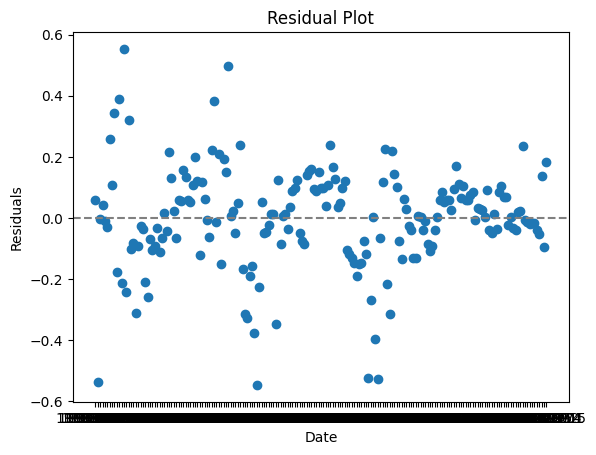

In [7]:
# Get the residuals
residuals = model.resid

# Create a DataFrame with 'Date' and residuals
residuals_df = pd.DataFrame({'Date': train['Date'], 'Residuals': residuals})

# Plot the residuals
fig, ax = plt.subplots()
ax.plot(residuals_df['Date'], residuals_df['Residuals'], marker='o', linestyle='None')
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
ax.set_title('Residual Plot')
plt.show()

###Validation Test

In [8]:
top_15_variable_names

3                                  CPI
25    Durable Goods Orders_RollingMean
6                 Durable Goods Orders
14             Average Hourly Earnings
5                         Retail Sales
24            Retail Sales_RollingMean
4                    Unemployment Rate
8         Long-Term Treasury Bond Rate
19        Standardized Sentiment Score
2                                Level
7        Short-Term Treasury Bond Rate
70                                risk
17                  Negative Frequency
83                           suggested
31                            appeared
Name: Variable, dtype: object

In [9]:
# Select the variables used in the model for the validation set
X_valid = valid[model.params.index[1:]]  # Exclude the constant term
X_valid = sm.add_constant(X_valid)  # Add a constant column if needed
y_valid = valid['Difference']

# Generate predictions on the validation set
y_pred = model.predict(X_valid)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_valid, y_pred)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared (R^2)
r2 = r2_score(y_valid, y_pred)

# Calculate adjusted R-squared (Adj R^2)
n_valid = len(y_valid)
k_valid = X_valid.shape[1]
adj_r2 = 1 - ((1 - r2) * (n_valid - 1)) / (n_valid - k_valid - 1)

# Calculate AICc
n = len(y_valid)
k = X_valid.shape[1]
aic = n * np.log(mse) + 2 * k + (2 * k * (k + 1)) / (n - k - 1)

print("Validation Mean Squared Error (MSE):", mse)
print("Validation Root Mean Squared Error (RMSE):", rmse)
print("Validation R-squared (R^2):", r2)
print("Validation Adjusted R-squared (Adj R^2):", adj_r2)
print("Validation AICc:", aic)

Validation Mean Squared Error (MSE): 0.07807856891604158
Validation Root Mean Squared Error (RMSE): 0.2794254263950251
Validation R-squared (R^2): -0.20128896682844588
Validation Adjusted R-squared (Adj R^2): -2.9470923195791796
Validation AICc: 48.51333374283501


###All variables

In [10]:
excluded_variables = ['Increase', 'Decrease', 'Date']
predictor_variables = train.drop(['Difference'] + excluded_variables, axis=1).columns
model = sm.OLS(train['Difference'], sm.add_constant(train[predictor_variables])).fit()

# Print the summary of the linear regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     7.217
Date:                Fri, 21 Jul 2023   Prob (F-statistic):           5.17e-20
Time:                        16:05:03   Log-Likelihood:                 228.16
No. Observations:                 191   AIC:                            -274.3
Df Residuals:                     100   BIC:                             21.63
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [11]:
# Calculate Mean Squared Error (MSE)
mse = model.mse_resid

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print MSE and RMSE
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
# Print the AIC and AICc
print("AIC:", model.aic)
print("AICc:", model.bic)

Mean Squared Error (MSE): 0.010255705256058012
Root Mean Squared Error (RMSE): 0.1012704559882003
AIC: -274.32713306802543
AICc: 21.62974888421786


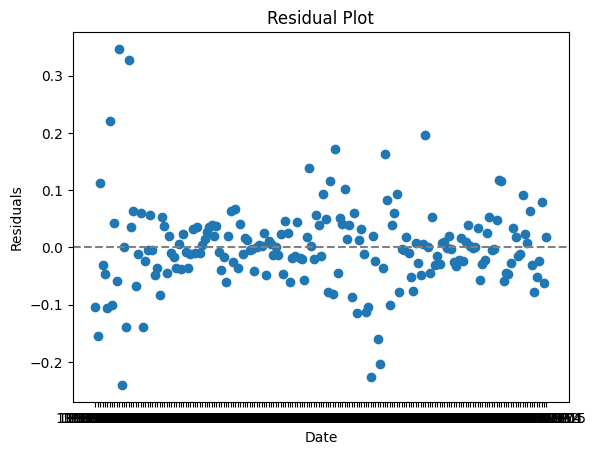

In [12]:
# Get the residuals
residuals = model.resid

# Create a DataFrame with 'Date' and residuals
residuals_df = pd.DataFrame({'Date': train['Date'], 'Residuals': residuals})

# Plot the residuals
fig, ax = plt.subplots()
ax.plot(residuals_df['Date'], residuals_df['Residuals'], marker='o', linestyle='None')
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
ax.set_title('Residual Plot')
plt.show()

In [13]:
# Prepare the validation data
X_valid = sm.add_constant(valid[predictor_variables])
y_valid = valid['Difference']

# Generate predictions on the validation set
y_pred = model.predict(X_valid)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_valid, y_pred)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared (R^2)
r2 = r2_score(y_valid, y_pred)

# Calculate adjusted R-squared (Adj R^2)
n_valid = len(y_valid)
k_valid = X_valid.shape[1]
adj_r2 = 1 - ((1 - r2) * (n_valid - 1)) / (n_valid - k_valid - 1)

# Calculate AICc
n = len(y_valid)
k = X_valid.shape[1]
aic = n * np.log(mse) + 2 * k + (2 * k * (k + 1)) / (n - k - 1)

# Print the accuracy metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R^2):", r2)
print("Adjusted R-squared (Adj R^2):", adj_r2)
print("AICc:", aic)


Mean Squared Error (MSE): 0.022231435903728055
Root Mean Squared Error (RMSE): 0.14910209892462298
R-squared (R^2): 0.6579550696347951
Adjusted R-squared (Adj R^2): 1.1092643527555515
AICc: -154.68328437409852


###Reverse Variable Selection (p-value)

In [14]:
def perform_reverse_variable_selection(X, y, threshold):
    model = sm.OLS(y, sm.add_constant(X)).fit()
    
    while True:
        p_values = model.pvalues[1:]  # Exclude the constant term
        
        # Find the predictor variable with the highest p-value
        max_p_value = p_values.max()
        if max_p_value <= threshold:
            break
        
        # Remove the predictor variable with the highest p-value
        max_p_var = p_values.idxmax()
        X = X.drop(max_p_var, axis=1)
        
        # Fit the model with the updated set of predictor variables
        model = sm.OLS(y, sm.add_constant(X)).fit()
    
    return model

# Perform reverse variable selection with a threshold of 0.05
threshold = 0.05
model_reverse_selection = perform_reverse_variable_selection(train[predictor_variables], train['Difference'], threshold)

# Print the summary of the linear regression results after variable selection
print(model_reverse_selection.summary())

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     30.71
Date:                Fri, 21 Jul 2023   Prob (F-statistic):           1.74e-49
Time:                        16:05:07   Log-Likelihood:                 201.22
No. Observations:                 191   AIC:                            -350.4
Df Residuals:                     165   BIC:                            -265.9
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [15]:
# Calculate Mean Squared Error (MSE)
mse = model_reverse_selection.mse_resid

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print MSE and RMSE
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("AIC:", model_reverse_selection.aic)
print("AICc:", model_reverse_selection.bic)

Mean Squared Error (MSE): 0.0082413998076717
Root Mean Squared Error (RMSE): 0.0907821557778383
AIC: -350.44386791182853
AICc: -265.88475878261613


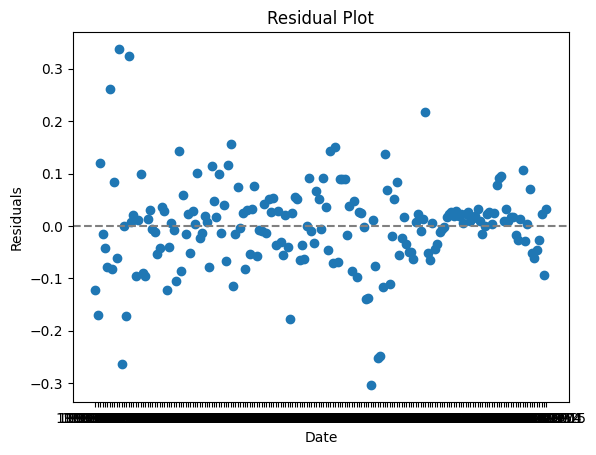

In [16]:
# Get the residuals
residuals = model_reverse_selection.resid

# Create a DataFrame with 'Date' and residuals
residuals_df = pd.DataFrame({'Date': train['Date'], 'Residuals': residuals})

# Plot the residuals
fig, ax = plt.subplots()
ax.plot(residuals_df['Date'], residuals_df['Residuals'], marker='o', linestyle='None')
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
ax.set_title('Residual Plot')
plt.show()

In [17]:
# Prepare the validation data with the selected predictor variables
X_valid = sm.add_constant(valid[model_reverse_selection.model.exog_names[1:]])
y_valid = valid['Difference']

# Generate predictions on the validation set
y_pred = model_reverse_selection.predict(X_valid)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_valid, y_pred)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared (R^2)
r2 = r2_score(y_valid, y_pred)

# Calculate adjusted R-squared (Adj R^2)
n_valid = len(y_valid)
k_valid = X_valid.shape[1]
adjusted_r_squared = 1 - (1 - r2) * (n_valid - 1) / (n_valid - k_valid - 1)

# Calculate AICc
n = len(y_valid)
k = X_valid.shape[1]
aic = n * np.log(mse) + 2 * k + (2 * k * (k + 1)) / (n - k - 1)

# Print the accuracy metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R^2):", r2)
print("Adjusted R-squared (Adj R^2):", adjusted_r_squared)
print("AICc:", aic)

Mean Squared Error (MSE): 0.02434537386673484
Root Mean Squared Error (RMSE): 0.15603004155205125
R-squared (R^2): 0.6254307753658961
Adjusted R-squared (Adj R^2): 2.723018433316878
AICc: -357.96992237860763


###Reverse variable selection (AICc) version

In [18]:
def perform_reverse_variable_selection_aicc(X, y):
    model = sm.OLS(y, sm.add_constant(X)).fit()
    n = len(y)
    k = X.shape[1] + 1  # Number of predictor variables + constant term
    aicc = model.aic + (2 * k * (k + 1)) / (n - k - 1)
    
    while True:
        aicc_values = []
        p_values = model.pvalues[1:]  # Exclude the constant term
        
        for var in X.columns:
            X_temp = X.drop(var, axis=1)
            model_temp = sm.OLS(y, sm.add_constant(X_temp)).fit()
            n_temp = len(y)
            k_temp = X_temp.shape[1] + 1
            aicc_temp = model_temp.aic + (2 * k_temp * (k_temp + 1)) / (n_temp - k_temp - 1)
            aicc_values.append(aicc_temp)
        
        min_aicc = np.min(aicc_values)
        if min_aicc < aicc:
            min_var_idx = np.argmin(aicc_values)
            X = X.drop(X.columns[min_var_idx], axis=1)
            aicc = min_aicc
            model = sm.OLS(y, sm.add_constant(X)).fit()
        else:
            break
    
    return model

# Perform reverse variable selection based on AICc
model_reverse_selection_aicc = perform_reverse_variable_selection_aicc(train[predictor_variables], train['Difference'])

# Print the summary of the linear regression results after variable selection
print(model_reverse_selection_aicc.summary())

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     31.07
Date:                Fri, 21 Jul 2023   Prob (F-statistic):           2.32e-50
Time:                        16:07:17   Log-Likelihood:                 205.72
No. Observations:                 191   AIC:                            -357.4
Df Residuals:                     164   BIC:                            -269.6
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [19]:
# Calculate Mean Squared Error (MSE)
mse = model_reverse_selection_aicc.mse_resid

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print MSE and RMSE
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("AIC:", model_reverse_selection.aic)
print("AICc:", model_reverse_selection.bic)

Mean Squared Error (MSE): 0.007910312346779627
Root Mean Squared Error (RMSE): 0.08893993673698912
AIC: -350.44386791182853
AICc: -265.88475878261613


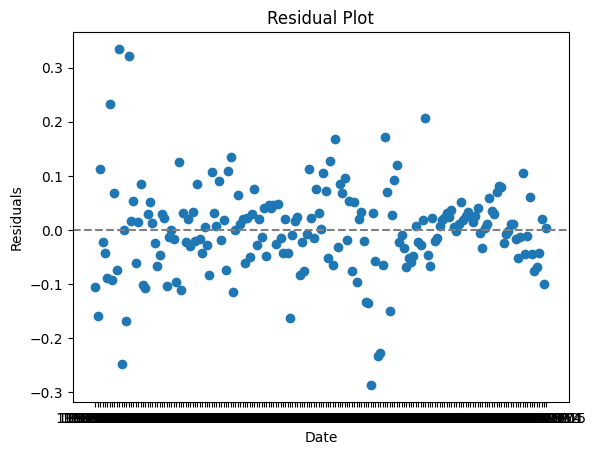

In [20]:
# Get the residuals
residuals = model_reverse_selection_aicc.resid

# Create a DataFrame with 'Date' and residuals
residuals_df = pd.DataFrame({'Date': train['Date'], 'Residuals': residuals})

# Plot the residuals
fig, ax = plt.subplots()
ax.plot(residuals_df['Date'], residuals_df['Residuals'], marker='o', linestyle='None')
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
ax.set_title('Residual Plot')
plt.show()

In [21]:
# Calculate the number of predictors (k)
k = model_reverse_selection_aicc.params.shape[0] - 1
n = len(y_pred)

# Print the values
print("Number of observations (n):", n)
print("Number of predictors (k):", k)

Number of observations (n): 24
Number of predictors (k): 26


In [22]:
# Prepare the validation data with the selected predictor variables
X_valid = sm.add_constant(valid[model_reverse_selection_aicc.model.exog_names[1:]])
y_valid = valid['Difference']

# Generate predictions on the validation set
y_pred = model_reverse_selection_aicc.predict(X_valid)

# Calculate the mean squared error (MSE)
mse = mean_squared_error(y_valid, y_pred)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared (R^2)
r2 = r2_score(y_valid, y_pred)

# Calculate adjusted R-squared (Adj R^2)
adj_r2 = 1 - (1 - r2) * ((n - 1)/(n-k-1))

# Calculate AICc
aic = n * np.log(mse) + 2 * k + (2 * k * (k + 1)) / (len(y_pred) - k - 1)

# Print the accuracy metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R^2):", r2)
print("Adjusted R-squared (Adj R^2):", adj_r2)
print("AICc:", aic)

Mean Squared Error (MSE): 0.03135641885101207
Root Mean Squared Error (RMSE): 0.1770774374419623
R-squared (R^2): 0.5175613420184855
Adjusted R-squared (Adj R^2): 4.698696377858278
AICc: -499.09607083574156


###Ridge regression

In [23]:
X_train = train.drop(['Difference', 'Date'], axis=1)
y_train = train['Difference']

X_test = test.drop(['Difference', 'Date'], axis=1)
y_test = test['Difference']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform RidgeCV
ridge = RidgeCV(cv=5)  # Set the number of cross-validation folds (e.g., 5)
ridge.fit(X_train_scaled, y_train)

# Get the best alpha chosen by RidgeCV
best_alpha = ridge.alpha_

# Fit the model with the best alpha to obtain the coefficients
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train_scaled, y_train)

# Perform prediction on the scaled test dataset
y_pred = ridge_best.predict(X_test_scaled)

# Calculate R-squared for test data
r2 = r2_score(y_test, y_pred)

# Calculate the number of model parameters
k = X_test.shape[1] + 1  # Number of predictor variables + intercept

# Calculate the number of data points
n = len(y_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)

# Calculate the AICc
aic = n * np.log(mse) + 2 * k + (2 * k * (k + 1)) / (n - k - 1)

print("Test Mean Squared Error (MSE):", mse)
print("Test Root Mean Squared Error (RMSE):", np.sqrt(mse))
print("Test R-squared (R^2):", r2)
print("AICc:", aic)

Test Mean Squared Error (MSE): 0.17759060610759414
Test Root Mean Squared Error (RMSE): 0.42141500460661596
Test R-squared (R^2): -1.1338657443123696
AICc: -104.39750315959014


In [24]:
ridge.alpha_

10.0

In [25]:
ridge = RidgeCV(cv=5)  # Set the number of cross-validation folds (e.g., 5)
ridge.fit(X_train_scaled, y_train)

# Get the best alpha chosen by RidgeCV
best_alpha = ridge.alpha_

# Fit the model with the best alpha to obtain the coefficients
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train_scaled, y_train)

# Get the coefficients
coefficients = ridge_best.coef_

# Print the coefficients
for feature, coef in zip(X.columns, coefficients):
    print(f"{feature}: {coef}")

const: -0.015169653112128293
CPI: -0.015267404560274622
Durable Goods Orders_RollingMean: 0.005979707991417003
Durable Goods Orders: 0.002824249725991123
Average Hourly Earnings: -0.030940478920694476
Retail Sales: 0.01676940071975081
Retail Sales_RollingMean: -0.012085798499806571
Unemployment Rate: -6.1220689248001155e-06
Long-Term Treasury Bond Rate: -0.01264049134924517
Standardized Sentiment Score: 0.0024195806302973054
Level: -0.02845613540549744
Short-Term Treasury Bond Rate: 0.0013670279651327318
risk: 0.0017190585773410386
Negative Frequency: -0.010323027123417065
suggested: 0.0035944720342686886
appeared: -0.0019397475713914616


###Validation Test

In [26]:
# Make predictions on the validation set
y_pred = ridge_best.predict(X_valid_scaled)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_valid, y_pred)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate the R-squared (R^2) score
r2 = r2_score(y_valid, y_pred)

# Calculate the adjusted R-squared score
n = len(y_valid)  # number of samples in the validation set
p = 16
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Calculate the AICc (Akaike Information Criterion corrected for small sample size)
aic = n * np.log(mse) + 2 * p + 2 * p * (p + 1) / (n - p - 1)

# Print the results
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")
print(f"Adjusted R^2: {adj_r2}")
print(f"AICc: {aic}")

NameError: name 'X_valid_scaled' is not defined